<h1><b><span style="color: #e56b6f; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Overview](#0)
* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Building Model with Sklearn](#5)
* [BUILDING MODEL WITH BERT AND LSTM](#6)
* [Prediction](#7)

<a id="0"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">OVERVIEW</span></b></h1>

In this notebook, we are going to do semantic analysis on hotel reviews. We will 2 different approaches:
1. With machine learning models using sklearn
2. With deep neural network 

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

**So, let's dive into the code!**

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud # type: ignore
import nltk
import string
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">LOADING DATASET</span></b></h1>

In [5]:
data = pd.read_csv('data/Hotel_Reviews.csv')
data
#print(f"Dataset shape: {data.shape}")

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/30/2015,8.1,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,14,2823,location,2,8,7.0,"[' Leisure trip ', ' Family with older childre...",704 day,48.203745,16.335677
515734,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/22/2015,8.1,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,11,2823,Breakfast was ok and we got earlier check in,11,12,5.8,"[' Leisure trip ', ' Family with young childre...",712 day,48.203745,16.335677
515735,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/19/2015,8.1,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,19,2823,No Positive,0,3,2.5,"[' Leisure trip ', ' Family with older childre...",715 day,48.203745,16.335677
515736,Wurzbachgasse 21 15 Rudolfsheim F nfhaus 1150 ...,168,8/17/2015,8.1,Atlantis Hotel Vienna,Mexico,No Negative,0,2823,The rooms are enormous and really comfortable...,25,3,8.8,"[' Leisure trip ', ' Group ', ' Standard Tripl...",717 day,48.203745,16.335677


In [6]:
print(f"Feature name : {data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

<b><span style="font-size: 15px"> To focus on the columns required for sentiment analysis, you'll typically need the text data for sentiment analysis and a label or score to train the model. Let's assume your dataset has columns like Hotel_Name, review (the text data) and Reviewer_Score (the sentiment label).</span></b>

In [7]:
# append the positive and negative text reviews
data["Review"] = data["Negative_Review"] + data["Positive_Review"]
# create the label
data["Rating"] = data["Reviewer_Score"]#.apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
df = data[["Hotel_Name","Review", "Rating"]]
df.head()

,Hotel_Name,Review,Rating
0,Hotel Arena,I am so angry that i made this post available...,2.9
1,Hotel Arena,No Negative No real complaints the hotel was g...,7.5
2,Hotel Arena,Rooms are nice but for elderly a bit difficul...,7.1
3,Hotel Arena,My room was dirty and I was afraid to walk ba...,3.8
4,Hotel Arena,You When I booked with your company on line y...,6.7


Sample data

In [8]:
df = df.sample(frac=0.1,replace=False,random_state=42)

In [9]:
#data.head()

<a id="3"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">DATA VISUALIZATION</span></b></h1>

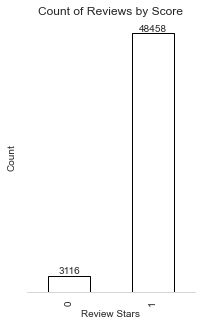

In [91]:
ax = df['Rating'].value_counts().sort_index(ascending=True) \
    .plot(kind='bar',title="Count of Reviews by Score", figsize=(3,5),color='None',edgecolor='black')
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')

for index, value in enumerate(df['Rating'].value_counts().sort_index(ascending=True)):
    plt.text(index, value, f"{value}", ha='center', va='bottom')
plt.grid(False)
plt.gca().set_yticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("CountOfReviewsByScore.pdf", format="pdf",bbox_inches="tight")
plt.show()

In [11]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)

df['Rating'] = df['Rating'].apply(lambda x : 1 if x>5 else 0)
df.head()

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,1,599
274649,Urban Lodge Hotel,No tissue paper box was present at the roomNo...,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,Pillows Nice welcoming and service,1,36
404352,Hotel Principe Di Savoia,No Negative Everything including the nice upgr...,1,166
451596,Hotel Esther a,No Negative Lovely hotel v welcoming staff,1,43


In [12]:
#Check for null values
df.isnull().sum()

Hotel_Name    0
Review        0
Rating        0
Length        0
dtype: int64

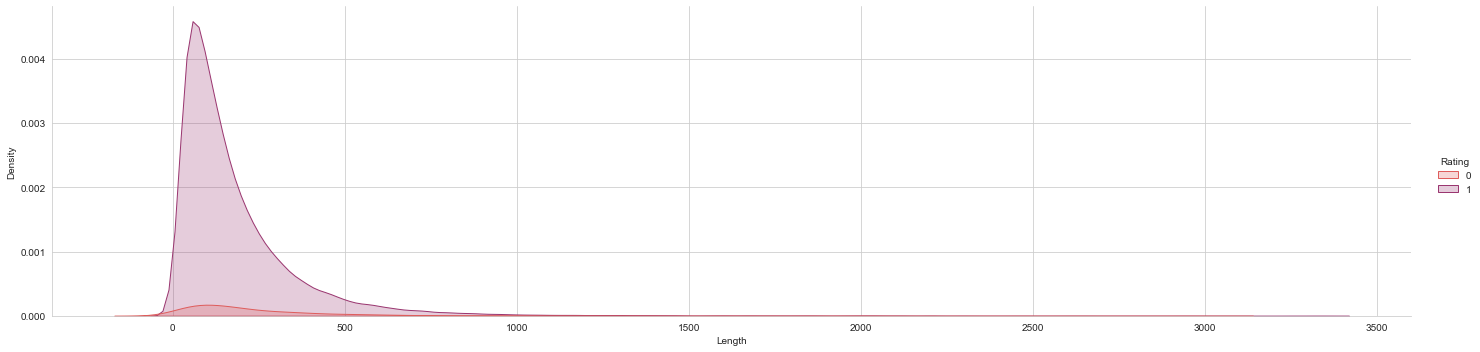

In [13]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

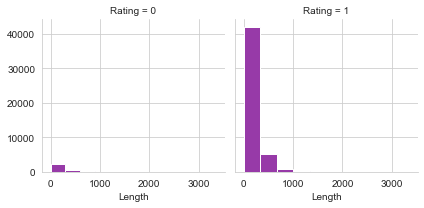

In [14]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

<AxesSubplot:xlabel='Rating', ylabel='Length'>

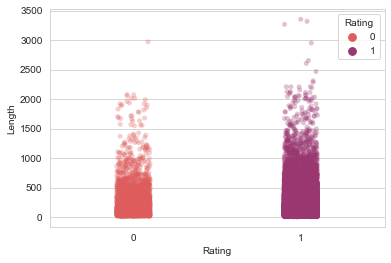

In [15]:
sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3,hue='Rating')


From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

<a id="4"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PREPROCESSING</span></b></h1>

In [16]:
df.head()

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,1,599
274649,Urban Lodge Hotel,No tissue paper box was present at the roomNo...,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,Pillows Nice welcoming and service,1,36
404352,Hotel Principe Di Savoia,No Negative Everything including the nice upgr...,1,166
451596,Hotel Esther a,No Negative Lovely hotel v welcoming staff,1,43


In [17]:
# Total word in dataset before cleaning
length = df['Length'].sum()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Stemming vs Lemmatization</b></h1>

In [18]:
print('Original:')
rows = 0
print(df['Review'].iloc[rows])
print()

sentence = []
for word in df['Review'].iloc[rows].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'].iloc[rows].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
 Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices  Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again 

Stemming:
would have appreci a shop in the hotel that sold drink water etc but not necess would recommend if like us you arriv late at night to bring drink from plane airport as there s no shop nearbi there is a minibar though if you want to pay those price hotel was great clean friend staff free breakfast everi morn with good select good wifi connect nice size room with bath fridg in r


This time, we will use Lemmatization in order to get the base form of the word

In [19]:
def cleaning(text):
    # Replace specific phrases
    text = text.replace("No Negative", "").replace("No Positive", "")
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    clean_text = [lemmatizer.lemmatize(word, 'v') for word in clean_text]

    return ' '.join(clean_text)

In [20]:
df['Review'] = df['Review'].apply(cleaning)
df

,Hotel_Name,Review,Rating,Length
488440,Hotel Da Vinci,would appreciate shop hotel sell drink water e...,1,599
274649,Urban Lodge Hotel,tissue paper box present room,1,55
374688,Alexandra Barcelona A DoubleTree by Hilton,pillow nice welcome service,1,36
404352,Hotel Principe Di Savoia,everything include nice upgrade hotel revamp s...,1,166
451596,Hotel Esther a,lovely hotel v welcome staff,1,43
...,...,...,...,...
274862,Urban Lodge Hotel,bathroom water easy make bathroom wet bath wal...,1,142
9732,Grand Royale London Hyde Park,room small chair tatty room,0,52
424201,NH Collection Barcelona Gran Hotel Calder n,expensive rat mini bar price roof top pool vie...,1,80
72380,Park Avenue Baker Street,loud ac machine right outside window affect sl...,1,176


In [21]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 9683221
Total text length after cleaning: 6217646


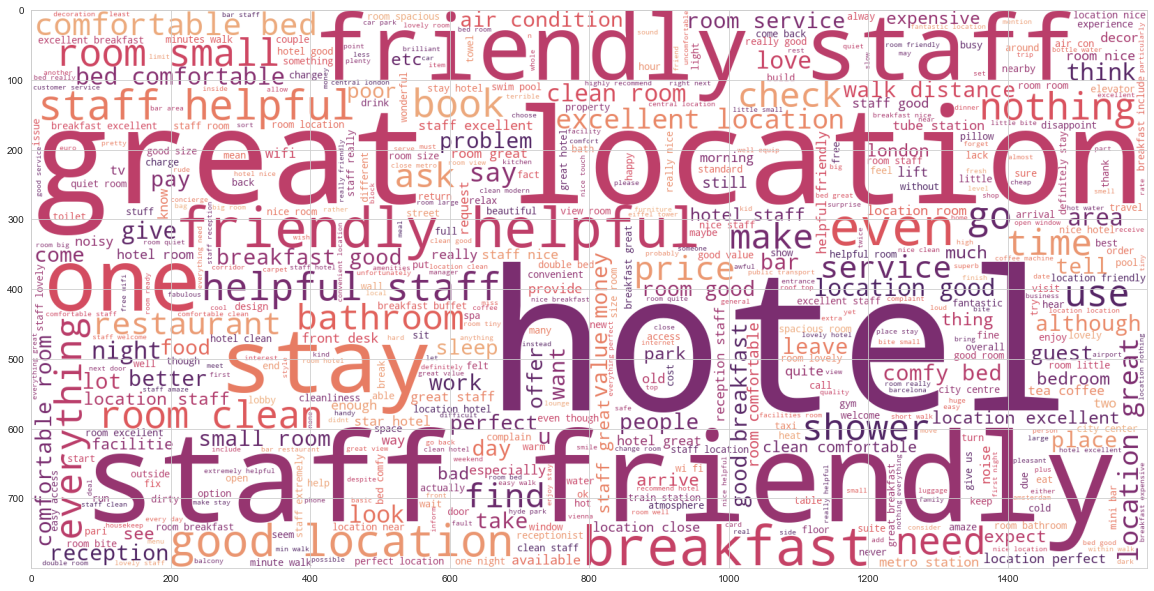

In [22]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

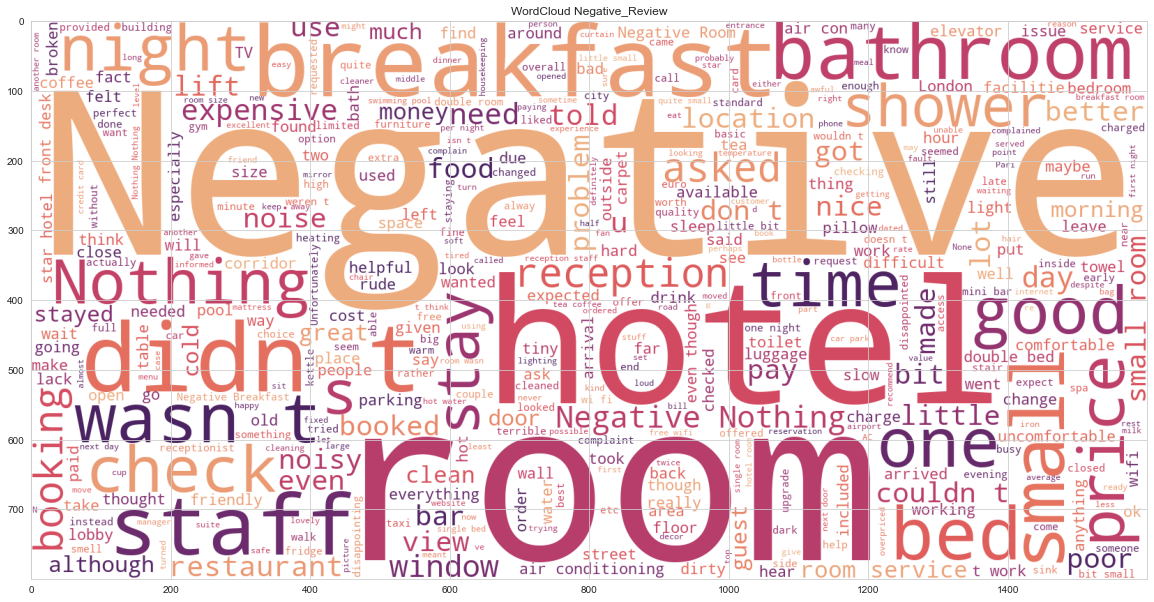

In [110]:
plt.figure(figsize=(20,20))
wc_negative_r = WordCloud(max_words=1000, min_font_size=10,
               height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(data["Negative_Review"]))
plt.title("WordCloud Negative_Review")
plt.imshow(wc_negative_r)
plt.savefig("WordCloudNegativeReview.pdf", format="pdf",bbox_inches="tight")

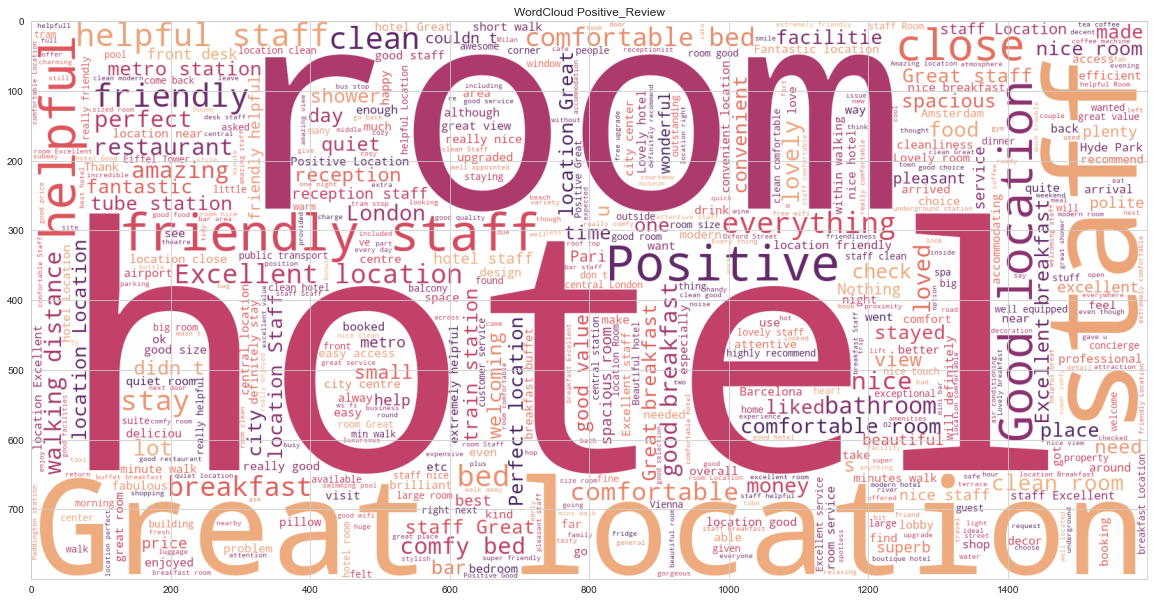

In [109]:
plt.figure(figsize=(20,20))
wc_positive_r = WordCloud(max_words=1000, min_font_size=10,
                          height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(data["Positive_Review"]))
plt.title("WordCloud Positive_Review")
plt.imshow(wc_positive_r)
plt.savefig("WordCloudPositiveReview.pdf", format="pdf",bbox_inches="tight")

In [25]:
df['Rating'].value_counts()

1    48458
0     3116
Name: Rating, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">BUILDING MODEL WITH SKLEARN</span></b></h1>


In [27]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [28]:
pickle.dump(tfid, open('models/tfidf.pkl', 'wb'))

In [29]:
models = [BernoulliNB(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          KNeighborsClassifier()
        ]

Confusion Matrix for BernoulliNB


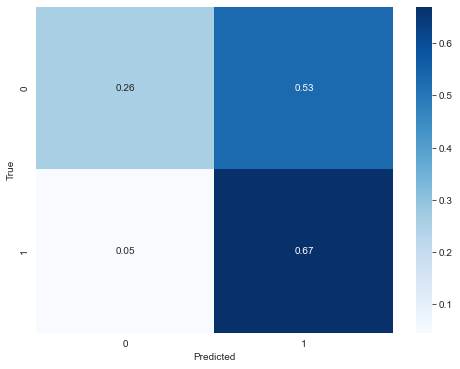


Confusion Matrix for RandomForestClassifier


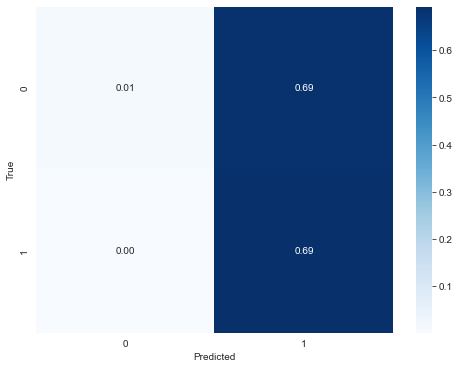


Confusion Matrix for SVC


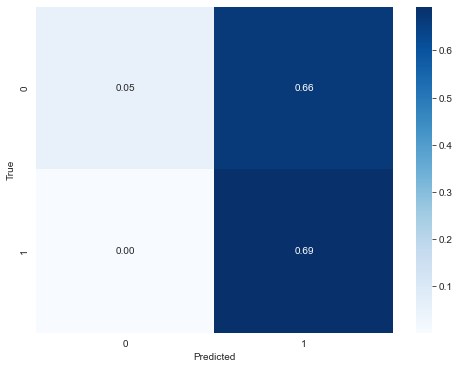


Confusion Matrix for LogisticRegression


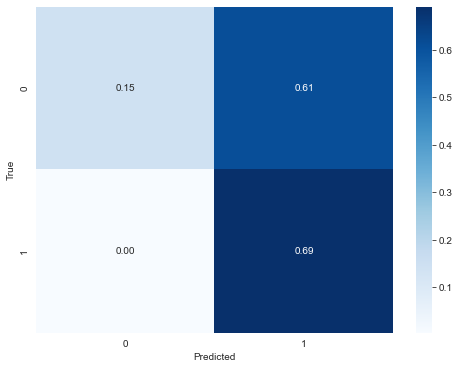


Confusion Matrix for DecisionTreeClassifier


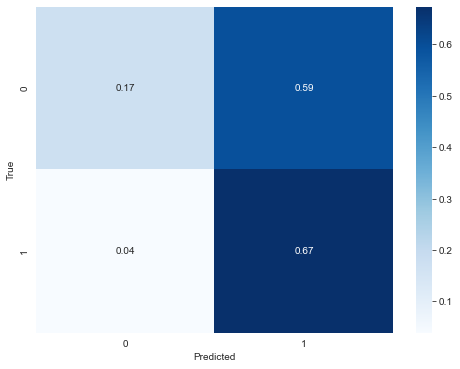


Confusion Matrix for KNeighborsClassifier


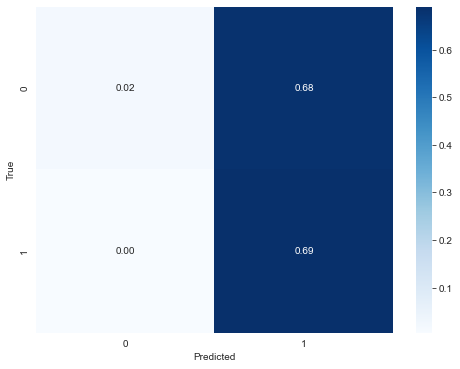

In [30]:
accuracy = []
precision = []
recall = []
f1_score = []
model_names = []

for model in models:
    model.fit(train_tfid_matrix, y_train)
    y_pred = model.predict(test_tfid_matrix)

    # Accuracy
    accuracy.append(model.score(test_tfid_matrix, y_test))

    # Precision, Recall, F1 Score
    report = classification_report(y_test, y_pred, output_dict=True)
    precision.append(report['macro avg']['precision'])
    recall.append(report['macro avg']['recall'])
    f1_score.append(report['macro avg']['f1-score'])
    # Store the model name
    model_names.append(type(model).__name__)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    print("Confusion Matrix for", type(model).__name__)
    # Use a heatmap with a logarithmic scale to better visualize the data
    #plt.title("Confusion Matrix for", type(model).__name__)
    plt.figure(figsize=(8, 6))
    sns.heatmap(np.log1p(cm), annot=True, fmt=".2f", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

In [31]:
# DataFrame with accuracy, precision, recall, and F1 score
#models_name = ['BernoulliNB', 'RandomForestClassifier', 'SVC','LogisticRegression']
results = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})
results

,Model,Accuracy,Precision,Recall,F1 Score
0,BernoulliNB,0.915463,0.617931,0.624997,0.621324
1,RandomForestClassifier,0.942511,0.721556,0.505542,0.496724
2,SVC,0.945128,0.895829,0.527516,0.538064
3,LogisticRegression,0.947940,0.833146,0.576512,0.615143
4,DecisionTreeClassifier,0.915851,0.587724,0.574532,0.580351
5,KNeighborsClassifier,0.939118,0.573370,0.507701,0.502688


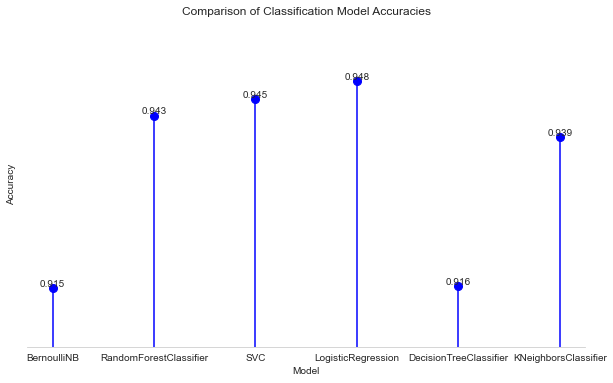

In [72]:
import matplotlib.pyplot as plt
models = results['Model'].tolist()
accuracy = results['Accuracy'].tolist()

# Create the vertical stem plot
plt.figure(figsize=(10, 6))
plt.title("Comparison of Classification Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
markerline, stemlines, baseline = plt.stem(range(len(models)), accuracy, basefmt=" ")

# Customize the markers and stems
plt.setp(markerline, marker='o', markersize=8, color='b')
plt.setp(stemlines, linestyle='-', color='b', linewidth=1.5)

# Annotate the accuracy values
for index, value in enumerate(accuracy):
    plt.text(index, value, f"{value:.3f}", ha='center', va='bottom')

# Customize x-ticks to show model names
plt.xticks(range(len(models)), models)

# Set y-axis limit to start from the minimum accuracy value
plt.ylim(min(accuracy) - (0.01 * min(accuracy)), max(accuracy) + (0.01 * max(accuracy)))
plt.grid(False)
plt.gca().set_yticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("ComparisonOfClassification.pdf", format="pdf",bbox_inches="tight")
plt.show()


Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [80]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

[1 1 1 ... 1 1 1]


In [35]:
pickle.dump(log, open('models/ml_model.pkl', 'wb'))

In [79]:
ml = pickle.load(open('models/ml_model.pkl','rb'))
tfidf = pickle.load(open('models/tfidf.pkl','rb'))

def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]
    sentiment = ''
    if pred == 1:
        sentiment = " Positive review :)"
    else:
        sentiment = " Negative review :("

    return text +  " ==> sentiment score: " + str(pred_proba[0][idx]) + sentiment

print(ml_predict('The room was small and dirty'))
print(ml_predict('The staff was friendly and we really enjoy the food at the hotel'))


the room was small and dirty ==> sentiment score: 0.8143048189539449 Negative review :(
The staff was friendly and we really enjoy the food at the hotel ==> sentiment score: 0.9936822505887616 Positive review :)


[[3 2]
 [0 5]]


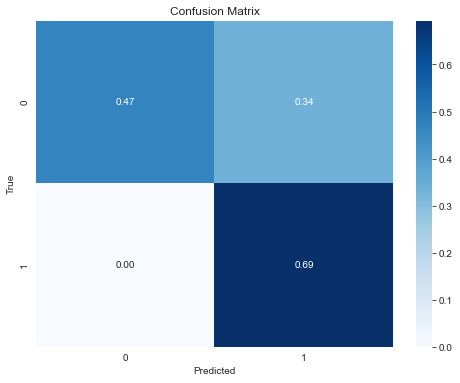

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



In [106]:
print(confusion_matrix(y_test, pred))

cm = confusion_matrix(y_test, pred, normalize='true')

# Use a heatmap with a logarithmic scale to better visualize the data
plt.figure(figsize=(8, 6))
sns.heatmap(np.log1p(cm), annot=True, fmt=".2f", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("ConfusionMatrix.pdf", format="pdf",bbox_inches="tight")
plt.show()

print(classification_report(y_test, pred))

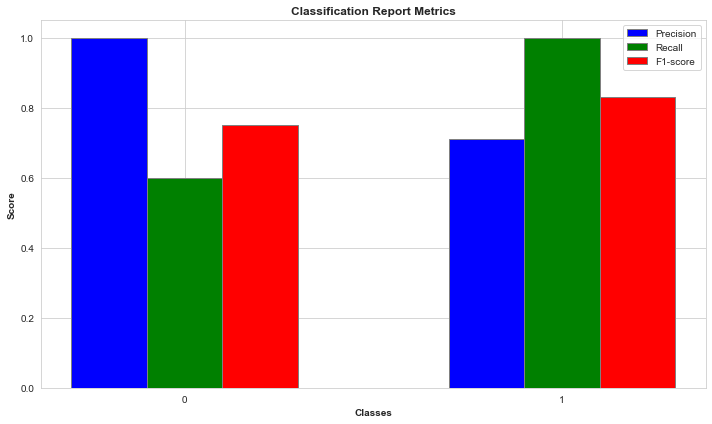

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the classification report
classes = ['0', '1']
precision = [1.00, 0.71]
recall = [0.60, 1.00]
f1_score = [0.75, 0.83]

# Plotting
plt.figure(figsize=(10, 6))

# Bar width
bar_width = 0.2

# Positions of bars on x-axis
r1 = range(len(classes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1-score')

# Add labels
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.ylabel('Score', fontweight='bold')
plt.title('Classification Report Metrics', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

